In [5]:
pip install gymnasium[mujoco]


In [6]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import random
import time

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward.reshape(-1, 1), next_state, done.reshape(-1, 1)

    def __len__(self):
        return len(self.buffer)

In [8]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action, hidden_dim=256):
        super(Actor, self).__init__()

        self.l1 = nn.Linear(state_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Linear(hidden_dim, action_dim)

        self.max_action = max_action
        self.action_dim = action_dim

    def forward(self, state):
        a = F.relu(self.l1(state))
        a = F.relu(self.l2(a))

        mean = self.mean(a)
        log_std = self.log_std(a)
        log_std = torch.clamp(log_std, min=-20, max=2)
        std = torch.exp(log_std)

        return mean, std

    def sample(self, state):
        mean, std = self.forward(state)
        normal = Normal(mean, std)

        x_t = normal.rsample()

        y_t = torch.tanh(x_t)
        action = y_t * self.max_action

        log_prob = normal.log_prob(x_t)

        log_prob -= torch.log(self.max_action * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)

        return action, log_prob

In [9]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()

        self.l1 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.l2 = nn.Linear(hidden_dim, hidden_dim)
        self.l3 = nn.Linear(hidden_dim, 1)

        self.l4 = nn.Linear(state_dim + action_dim, hidden_dim)
        self.l5 = nn.Linear(hidden_dim, hidden_dim)
        self.l6 = nn.Linear(hidden_dim, 1)

    def forward(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        q2 = F.relu(self.l4(sa))
        q2 = F.relu(self.l5(q2))
        q2 = self.l6(q2)

        return q1, q2

    def Q1(self, state, action):
        sa = torch.cat([state, action], 1)

        q1 = F.relu(self.l1(sa))
        q1 = F.relu(self.l2(q1))
        q1 = self.l3(q1)

        return q1

In [10]:
class SAC:
    def __init__(
        self,
        state_dim,
        action_dim,
        max_action,
        hidden_dim=256,
        discount=0.99,
        tau=0.005,
        lr=3e-4,
        alpha=0.2,
        automatic_entropy_tuning=True
    ):
        self.gamma = discount
        self.tau = tau
        self.alpha = alpha
        self.automatic_entropy_tuning = automatic_entropy_tuning

        self.actor = Actor(state_dim, action_dim, max_action, hidden_dim).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)

        self.critic = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim).to(device)

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data)

        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)

        if self.automatic_entropy_tuning:
            self.target_entropy = -torch.prod(torch.Tensor([action_dim]).to(device)).item()
            self.log_alpha = torch.zeros(1, requires_grad=True, device=device)
            self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr)

    def select_action(self, state, evaluate=False):
        state = torch.FloatTensor(state).to(device).unsqueeze(0)

        if evaluate:
            with torch.no_grad():
                mean, _ = self.actor(state)
                return torch.tanh(mean) * self.actor.max_action
        else:
            with torch.no_grad():
                action, _ = self.actor.sample(state)
                return action.cpu().data.numpy().flatten()

    def update_parameters(self, replay_buffer, batch_size=256):
        state, action, reward, next_state, done = replay_buffer.sample(batch_size)

        state = torch.FloatTensor(state).to(device)
        action = torch.FloatTensor(action).to(device)
        reward = torch.FloatTensor(reward).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).to(device)

        with torch.no_grad():
            next_action, next_log_pi = self.actor.sample(next_state)

            target_q1, target_q2 = self.critic_target(next_state, next_action)
            target_q = torch.min(target_q1, target_q2)

            target_q = reward + (1 - done) * self.gamma * (target_q - self.alpha * next_log_pi)

        current_q1, current_q2 = self.critic(state, action)

        critic_loss = F.mse_loss(current_q1, target_q) + F.mse_loss(current_q2, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        actions, log_pi = self.actor.sample(state)
        q1, q2 = self.critic(state, actions)
        min_q = torch.min(q1, q2)

        actor_loss = (self.alpha * log_pi - min_q).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        if self.automatic_entropy_tuning:
            alpha_loss = -(self.log_alpha * (log_pi + self.target_entropy).detach()).mean()

            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()

            self.alpha = self.log_alpha.exp()

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return {
            'critic_loss': critic_loss.item(),
            'actor_loss': actor_loss.item(),
            'alpha': self.alpha.item() if self.automatic_entropy_tuning else self.alpha
        }

    def save(self, directory, name):
        if not os.path.exists(directory):
            os.makedirs(directory)

        torch.save(self.actor.state_dict(), f"{directory}/{name}_actor.pth")
        torch.save(self.critic.state_dict(), f"{directory}/{name}_critic.pth")

    def load(self, directory, name):
        self.actor.load_state_dict(torch.load(f"{directory}/{name}_actor.pth"))
        self.critic.load_state_dict(torch.load(f"{directory}/{name}_critic.pth"))

In [11]:
def evaluate_agent(agent, env, eval_episodes=10):
    avg_reward = 0.
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False

        while not done:
            action = agent.select_action(state, evaluate=True)
            next_state, reward, terminated, truncated, _ = env.step(action.cpu().numpy().flatten())
            done = terminated or truncated

            avg_reward += reward
            state = next_state

    avg_reward /= eval_episodes

    return avg_reward

def plot_results(rewards, eval_rewards, actor_losses, critic_losses, alphas, env_name):

    plt.figure(figsize=(10, 6))
    plt.plot(rewards)
    plt.title(f"Training Rewards - {env_name}")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.savefig(f"{env_name}_training_rewards.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(eval_rewards)
    plt.title(f"Evaluation Rewards - {env_name}")
    plt.xlabel("Evaluation Steps")
    plt.ylabel("Reward")
    plt.tight_layout()
    plt.savefig(f"{env_name}_eval_rewards.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(actor_losses, label="Actor Loss")
    plt.plot(critic_losses, label="Critic Loss")
    plt.title("Losses")
    plt.xlabel("Update Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{env_name}_losses.png")
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(alphas)
    plt.title("Alpha (Temperature Parameter)")
    plt.xlabel("Update Steps")
    plt.ylabel("Alpha")
    plt.tight_layout()
    plt.savefig(f"{env_name}_alpha.png")
    plt.show()

In [12]:
def train_sac(env_name, max_steps=300_000, eval_freq=5000, eval_episodes=10,
              batch_size=256, buffer_size=1_000_000):

    try:
        env = gym.make(env_name)
        eval_env = gym.make(env_name)
    except:
        new_env_name = env_name.replace("-v4", "-v3")
        print(f"Trying {new_env_name} instead...")
        env = gym.make(new_env_name)
        eval_env = gym.make(new_env_name)
        env_name = new_env_name

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    max_action = float(env.action_space.high[0])

    print(f"State dim: {state_dim}, Action dim: {action_dim}, Max action: {max_action}")

    agent = SAC(
        state_dim=state_dim,
        action_dim=action_dim,
        max_action=max_action,
        hidden_dim=256,
        discount=0.99,
        tau=0.005
    )

    replay_buffer = ReplayBuffer(buffer_size)

    rewards = []
    eval_rewards = []
    actor_losses = []
    critic_losses = []
    alphas = []

    state, _ = env.reset()
    episode_reward = 0
    episode_steps = 0
    episode_num = 0

    for t in range(max_steps):
        if t < 10000:
            action = env.action_space.sample()
        else:
            action = agent.select_action(state)

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        replay_buffer.push(state, action, reward, next_state, float(done))

        state = next_state
        episode_reward += reward
        episode_steps += 1

        if len(replay_buffer) > batch_size:
            metrics = agent.update_parameters(replay_buffer, batch_size)

            actor_losses.append(metrics['actor_loss'])
            critic_losses.append(metrics['critic_loss'])
            alphas.append(metrics['alpha'])

        if done:
            print(f"Episode {episode_num}: Reward = {episode_reward}, Steps = {episode_steps}")
            rewards.append(episode_reward)

            state, _ = env.reset()
            episode_reward = 0
            episode_steps = 0
            episode_num += 1

        if (t + 1) % eval_freq == 0:
            eval_reward = evaluate_agent(agent, eval_env, eval_episodes)
            eval_rewards.append(eval_reward)
            print(f"Step {t+1}: Evaluation over {eval_episodes} episodes: {eval_reward}")

            agent.save("./models", f"{env_name}")

    plot_results(rewards, eval_rewards, actor_losses, critic_losses, alphas, env_name)

    return agent, rewards, eval_rewards

/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


State dim: 17, Action dim: 6, Max action: 1.0
Episode 0: Reward = -490.9909969312645, Steps = 1000
Episode 1: Reward = -149.1552305854148, Steps = 1000
Episode 2: Reward = -437.6300430275108, Steps = 1000
Episode 3: Reward = -313.72867146328116, Steps = 1000
Episode 4: Reward = -311.8993395585875, Steps = 1000
Step 5000: Evaluation over 10 episodes: -235.57440957006597
Episode 5: Reward = -466.266115689871, Steps = 1000
Episode 6: Reward = -240.00243051011176, Steps = 1000
Episode 7: Reward = -337.1382820982187, Steps = 1000
Episode 8: Reward = -156.1511731369593, Steps = 1000
Episode 9: Reward = -223.4454868650958, Steps = 1000
Step 10000: Evaluation over 10 episodes: -497.5888400763508


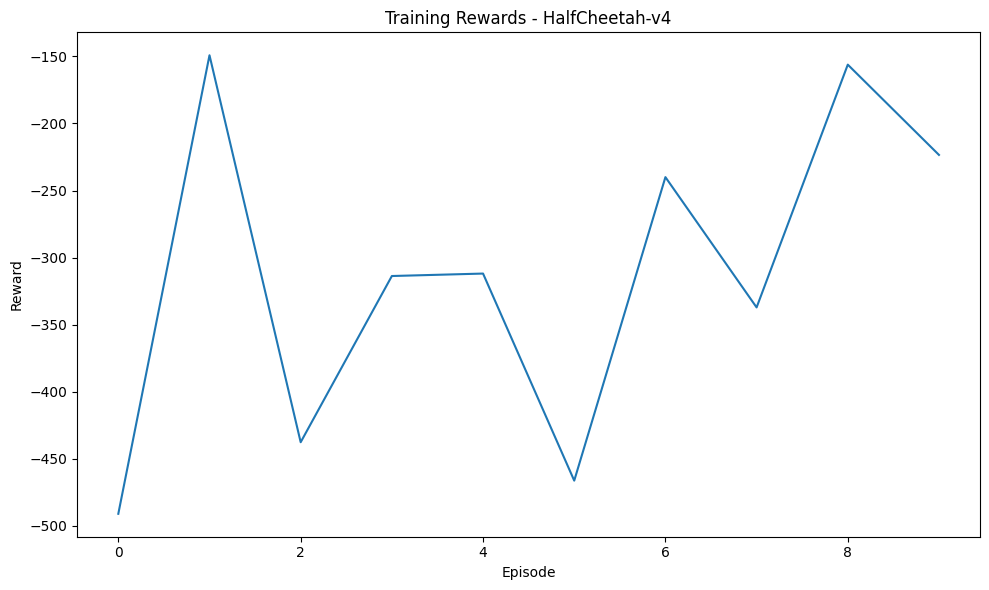

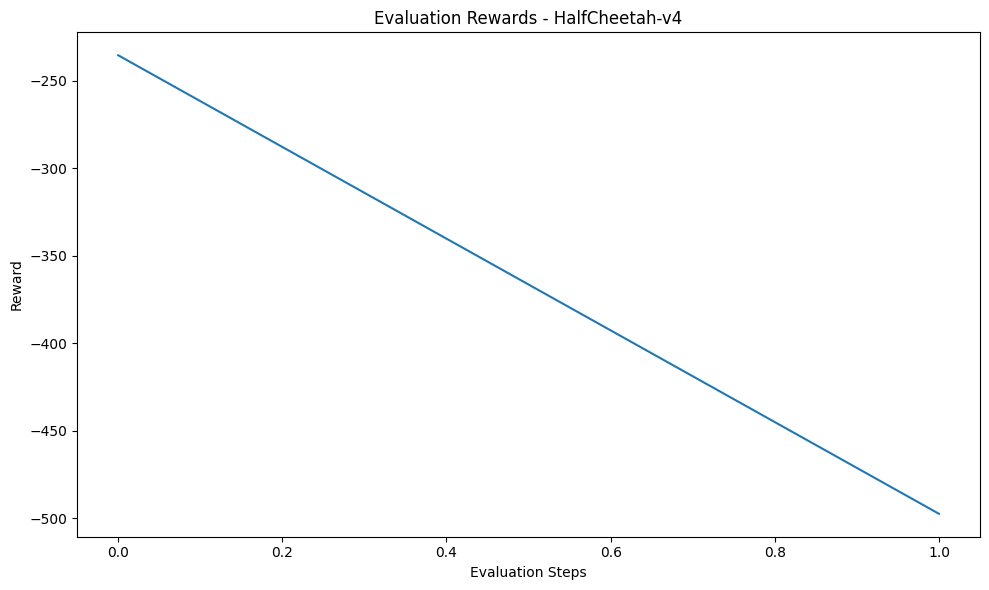

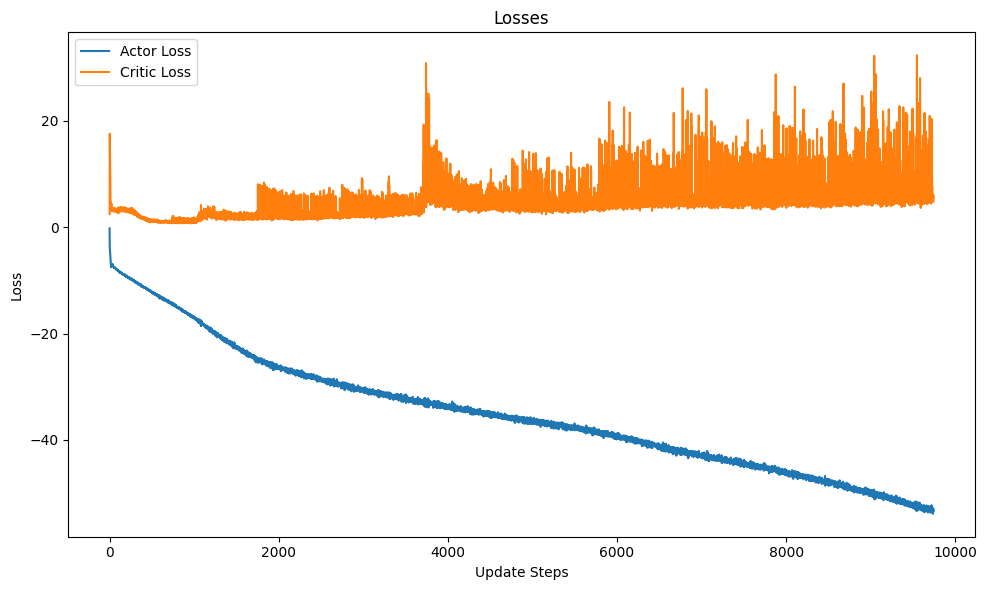

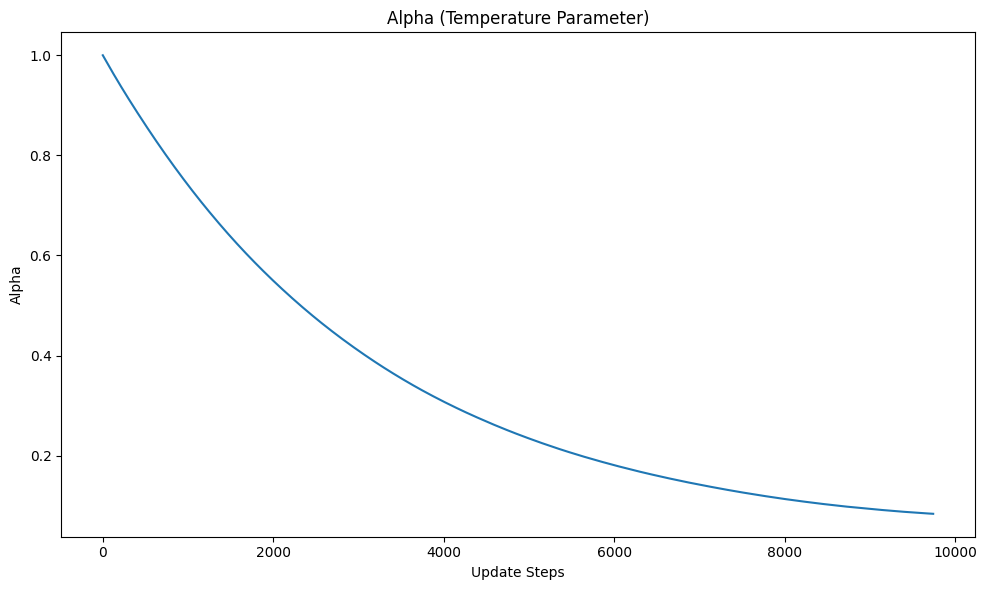

In [ ]:
if __name__ == "__main__":
    env_name = "HalfCheetah-v4"


    start_time = time.time()
    agent, rewards, eval_rewards = train_sac(env_name, max_steps=10_000, eval_freq=5000)
    end_time = time.time()

    print(f"Training completed in {(end_time - start_time) / 60:.2f} minutes")

    try:
        eval_env = gym.make(env_name, render_mode="human")
        final_reward = evaluate_agent(agent, eval_env, eval_episodes=5)
        print(f"Final evaluation: {final_reward}")
    except Exception as e:
        print(f"Rendering failed: {e}")
        print("Running final evaluation without rendering...")
        eval_env = gym.make(env_name)
        final_reward = evaluate_agent(agent, eval_env, eval_episodes=5)
        print(f"Final evaluation: {final_reward}")